In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

from utils.data_reader import read_IHDP_data, read_SIPP_data

from model.model_metrics import AIPW_Metrics, TarReg_Metrics, Base_Metrics
from model.model_loss import Base_Dragon_Loss, TarReg_Loss, MSE_Loss, CFRNet_Loss
from model.models import TARNet, CFRNet, DragonNetAIPW, DragonNetTR
from model.common_layer import RepresentLayer, HypothesisLayer, EpsilonLayer

In [27]:
import os
import math
import time
import datetime
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD, Adam

In [24]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baseline Results

In the following, we report estimated ITE (individualized conditional treatment effect) and ATE (average treatment effect) on the baseline dataset IHDP using default hyperparameters as suggested by Koch (https://github.com/kochbj/Deep-Learning-for-Causal-Inference). Example of command: </br>

    !python3 main.py --model tarnet
    
We find the baseline TARNet model slightly performs better than the DragonNet, the CFRNet diverges in training.

In [37]:
tar_result = np.load('./save/pred_result/pred_result_tarnet_IHDP.npy', allow_pickle=True)
dra_result = np.load('./save/pred_result/pred_result_dragonnet_IHDP.npy', allow_pickle=True)
draTR_result = np.load('./save/pred_result/pred_result_dragonnetTR_IHDP.npy', allow_pickle=True)

tar_result = tar_result.item()
dra_result = dra_result.item()
draTR_result = draTR_result.item()

tar_cate_pred = tar_result['cate_pred'].squeeze()
dra_cate_pred = dra_result['cate_pred'].squeeze()
draTR_cate_pred = draTR_result['cate_pred'].squeeze()
cate_true = tar_result['cate_true'].squeeze()

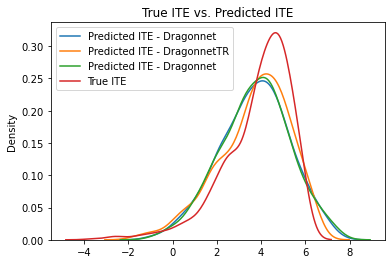

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt
pite_draggon = sns.kdeplot(dra_cate_pred, palette = 'blue', label = 'Predicted ITE - Dragonnet')
pite_draggonTR = sns.kdeplot(draTR_cate_pred, palette = 'green', label = 'Predicted ITE - DragonnetTR')
pite_tar = sns.kdeplot(tar_cate_pred, palette = 'blue', label = 'Predicted ITE - Dragonnet')
tite = sns.kdeplot(cate_true, palette = 'red', label = 'True ITE')
plt.title("True ITE vs. Predicted ITE")
plt.legend()
plt.show()

In [48]:
print("Estimated ATE from TARNet, DragonNet and DragonNet with Targetted Regularization are: ")
tf.print(tar_result['ate_pred']),
tf.print(dra_result['ate_pred'])
tf.print(draTR_result['ate_pred'])
print('True ATE is 3.8536534')

Estimated ATE from TARNet, DragonNet and DragonNet with Targetted Regularization are: 
3.72563434
3.70369434
3.68628263
True ATE is 3.8536534


## Fine-tuning of hyperparameters

We tune the hyperparameters of our models (TARNet, CFRNet, DragonNet, DragonNetTR) on Google Colab using a GPU and save the best model using Keras Tuner
https://www.tensorflow.org/tutorials/keras/keras_tuner